# Data pre-processing
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

## 1. Integrácia a čistenie dát

### Zadanie  
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
    
### Riešenie


In [2]:
# read labor and profiles dataset
df_labor = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles = pd.read_csv('../../data/profiles.csv', sep='\t')

# TODO: 
 - Doriešiť chýbajúce hodnoty

#### 1. Dataset profilov

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný

In [3]:
df_profiles=df_profiles.drop("Unnamed: 0", axis=1)
df_profiles.head()

,name,sex,current_location,blood_group,residence,birthdate,race,ssn,address
0,Elizabeth Johnson,F,"(Decimal('-64.545933'), Decimal('5.817377'))",B-,"319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067","10/30/1938, 00:00:00",White,518-82-6493,"09441 Joyce Route Suite 717\nWest Megan, GA 12969"
1,Scott Holmes,M,"(Decimal('-18.8183775'), Decimal('94.375497'))",A-,"28739 Hoffman Valleys Apt. 636\nMichaelville, ...",1927-06-20,Black,015-03-8632,USNS Miller\nFPO AE 08377
2,William Roth,M,"(Decimal('35.903361'), Decimal('-133.029344'))",B-,"8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...",1965-10-02,Black,898-78-8500,"7747 Nicole Wells\nShannonside, MI 84296"
3,Kimberly Barnes,F,"(Decimal('55.2055095'), Decimal('-121.665483'))",B+,Unit 0522 Box 6156\nDPO AE 24368,1962-02-14,White,478-72-0155,"228 Colleen Extension\nLake Morgan, AL 34806"
4,Sarah Escobar,F,"(Decimal('49.512264'), Decimal('-121.259776'))",AB-,"30306 Molina Junction\nPort Edwardview, OK 72746",02 Oct 1936,Indian,683-31-6335,"08249 Gentry Fall\nLewisshire, NY 20037"


 - **Atribút name** - tento stĺpec je v poriadku, kódovať do numerického tvaru ho nebudeme, potrebný pre spojenie 2 dataframeov, avšak po spojení dataframov sa stane nepotrebný 

In [4]:
df_profiles["name"].head()

0    Elizabeth Johnson
1         Scott Holmes
2         William Roth
3      Kimberly Barnes
4        Sarah Escobar
Name: name, dtype: object

 - **Atribút sex** - tento stĺpec treba pretransformovať z typu *_object_* na numerický typ nasledovne: **1 - žena**, **0 - muž**

In [5]:
df_profiles["sex"].head()

0    F
1    M
2    M
3    F
4    F
Name: sex, dtype: object

In [6]:
df_profiles["sex"].replace({"M": 0, "F": 1}, inplace=True)
df_profiles = df_profiles.astype({'sex': 'category'})
df_profiles["sex"].value_counts()

0    1557
1    1507
Name: sex, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty M a F za 0 a 1 ako dokazuje nasledovná bunka:

In [7]:
df_profiles["sex"].head()

0    1
1    0
2    0
3    1
4    1
Name: sex, dtype: category
Categories (2, int64): [0, 1]

# TODO:
- **Atribbút current_location** - tento nebudeme potrebovať pri strojovom učení, nebudeme riešiť kódovanie na numerický tvar, ale jeho vymazanie

In [8]:
df_profiles["current_location"].head()

0       (Decimal('-64.545933'), Decimal('5.817377'))
1     (Decimal('-18.8183775'), Decimal('94.375497'))
2     (Decimal('35.903361'), Decimal('-133.029344'))
3    (Decimal('55.2055095'), Decimal('-121.665483'))
4     (Decimal('49.512264'), Decimal('-121.259776'))
Name: current_location, dtype: object

 - **Atribút blood_group** - hodnoty typu *_object_* kategorizujeme nasledovne: **1(A+), 2(A-), 3(B+), 4(B-), 5(AB+), 6(AB-), 7(O+) a 8(O-)**

In [9]:
df_profiles['blood_group']

0        B-
1        A-
2        B-
3        B+
4       AB-
       ... 
3059    AB+
3060     O+
3061     B+
3062     B-
3063    AB+
Name: blood_group, Length: 3064, dtype: object

In [10]:
df_profiles['blood_group'] = df_profiles['blood_group'].replace({"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8})
df_profiles = df_profiles.astype({'blood_group': 'category'})
df_profiles.blood_group.value_counts()

1    398
3    395
8    394
7    389
5    388
2    377
6    364
4    359
Name: blood_group, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty za 1, 2, 3, 4, 5, 6, 7 a 8 ako dokazuje nasledovná bunka:

In [11]:
df_profiles["blood_group"].head()

0    4
1    2
2    4
3    3
4    6
Name: blood_group, dtype: category
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]

# TODO:
- **Atribút residence** - tento stĺpec je v poriadku, avšak pri strojovom učení nebudeme ho potrebovať, a preto ho odstránime:

In [12]:
df_profiles["residence"].head()

0    319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067
1    28739 Hoffman Valleys Apt. 636\nMichaelville, ...
2    8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...
3                     Unit 0522 Box 6156\nDPO AE 24368
4     30306 Molina Junction\nPort Edwardview, OK 72746
Name: residence, dtype: object

 - **Atribút birthdate** - neobsahuje žiadne chýbajúce hodnoty, avšak je potrebné získať jednotný tvar, pretože súčasný tvar je rôznorodý a zároveň nie je potrebné pre naše účely dátum narodenia pacienta, avšak súčasný vek pacienta môže byť potrebný, a preto nahradíme dátum narodenia za súčasný vek pacienta, ktorý môže byť pre nás viac informatívny

In [13]:
df_profiles['birthdate'] = df_profiles['birthdate'].astype('datetime64[ns]')
df_profiles['birthdate'].head()

0   1938-10-30
1   1927-06-20
2   1965-10-02
3   1962-02-14
4   1936-10-02
Name: birthdate, dtype: datetime64[ns]

In [14]:
df_profiles['birthdate'].isna().value_counts()

False    3064
Name: birthdate, dtype: int64

In [15]:
def age(born):
    """
    Computes current age.
    
    :param born: Date of birth 
    returns: Current age
    """
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df_profiles['age'] = df_profiles['birthdate'].apply(age)
df_profiles['age'].head()

0    83
1    94
2    56
3    59
4    85
Name: age, dtype: int64

 - **Atribút race** - neobsahuje žiadne chýbajúce hodnoty, hodnoty kategorizujeme nasledovne: **1(White), 2(Black), 3(Asian), 4(Hawaiian), 5(Indian)**

In [16]:
df_profiles.race.value_counts()

White       1565
Black        722
Asian        281
Hawaiian     170
Indian       159
black        102
white         36
blsck         29
Name: race, dtype: int64

Najskôr musíme upraviť hodnoty kde je chyba a ktoré majú na začiatku malé písmeno namiesto veľkého.

In [17]:
df_profiles['race'] = df_profiles['race'].replace({"blsck": "Black", "black": "Black", "white": "White"})
df_profiles.race.value_counts()

White       1601
Black        853
Asian        281
Hawaiian     170
Indian       159
Name: race, dtype: int64

Následne tieto hodnoty kategorizujeme ako sme uviedli vyššie.

In [18]:
df_profiles['race'] = df_profiles['race'].replace({"White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5})
df_profiles = df_profiles.astype({'race': 'category'})
df_profiles.race.value_counts()

1    1601
2     853
3     281
4     170
5     159
Name: race, dtype: int64

In [19]:
df_profiles["race"].head()

0    1
1    2
2    2
3    1
4    5
Name: race, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

# TODO:
- **Atribút ssn** - tento stĺpec je v poriadku, avšak po spojení dataframeov je nepotrebný pre naše účely, preto ho odstránime

In [20]:
df_profiles["ssn"].head()

0    518-82-6493
1    015-03-8632
2    898-78-8500
3    478-72-0155
4    683-31-6335
Name: ssn, dtype: object

 - **Atribút address** - tento stĺpec je celý v poriadku, avšak nepotrebný pre naše účely, preto ho nebudeme transformovať, ale odstránime ho

In [21]:
df_profiles["address"].head()

0    09441 Joyce Route Suite 717\nWest Megan, GA 12969
1                            USNS Miller\nFPO AE 08377
2             7747 Nicole Wells\nShannonside, MI 84296
3         228 Colleen Extension\nLake Morgan, AL 34806
4              08249 Gentry Fall\nLewisshire, NY 20037
Name: address, dtype: object

#### Dataset laboratórnych výsledkov  

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný

In [22]:
df_labor=df_labor.drop("Unnamed: 0", axis=1)
df_labor.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,name,alt,hbver,smoker,erytrocyty,er-cv,indicator,ssn,hematokrit
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,Kathryn Wagner,2.01576,9.04461,no,7.94417,61.31451,0.0,887-91-9698,5.40103
1,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,Frank Becker,0.81519,9.09262,no,5.33302,58.00624,0.0,506-37-0250,7.68167
2,5.37162,7.36106,7.10989,63.61518,6.95232,65.33091,74.23784,married,Stephanie Lewis,0.79787,6.18215,no,6.38771,62.73102,1.0,331-52-1241,6.27422
3,4.60987,8.04010,4.97779,30.35294,6.63243,67.33708,34.67995,married,Luis Williams,0.83917,5.22920,no,5.05640,62.60592,1.0,407-22-7513,6.61263
4,5.97408,6.66899,5.58872,97.97181,6.18242,67.48751,89.31030,divoced,Donald Hall,1.20122,4.97805,yes,5.10205,59.32470,1.0,486-30-7935,6.23117


 - **Atribút hemoglobin** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *_priemerom_*

In [23]:
hemoglobin_mean = df_labor["hemoglobin"].mean()
df_labor["hemoglobin"].loc[df_labor["hemoglobin"].isna(),].fillna(hemoglobin_mean)

320     6.416198
627     6.416198
835     6.416198
905     6.416198
1505    6.416198
1804    6.416198
1861    6.416198
1913    6.416198
1950    6.416198
2502    6.416198
3562    6.416198
3657    6.416198
3784    6.416198
4190    6.416198
4813    6.416198
4963    6.416198
5462    6.416198
5491    6.416198
5791    6.416198
6038    6.416198
6288    6.416198
7217    6.416198
7558    6.416198
8075    6.416198
8257    6.416198
8346    6.416198
8971    6.416198
9335    6.416198
9430    6.416198
9873    6.416198
Name: hemoglobin, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [24]:
df_labor["hemoglobin"].loc[df_labor["hemoglobin"].isna(),].count()

0

 - **Atribút leukocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *_priemerom_*

In [25]:
leukocyty_mean = df_labor["leukocyty"].mean()
df_labor["leukocyty"].loc[df_labor["leukocyty"].isna(),].fillna(leukocyty_mean)

187      6.777737
390      6.777737
398      6.777737
563      6.777737
588      6.777737
640      6.777737
923      6.777737
1577     6.777737
1950     6.777737
2467     6.777737
2809     6.777737
2817     6.777737
3368     6.777737
3618     6.777737
3677     6.777737
4473     6.777737
4658     6.777737
4882     6.777737
4919     6.777737
5743     6.777737
7035     6.777737
7083     6.777737
7218     6.777737
7324     6.777737
7555     6.777737
8500     6.777737
9219     6.777737
9593     6.777737
9691     6.777737
9869     6.777737
10021    6.777737
Name: leukocyty, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [26]:
df_labor["leukocyty"].loc[df_labor["leukocyty"].isna(),].count()

0

 - **Atribút etytr** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [27]:
df_labor["etytr"].loc[df_labor["etytr"].isna()]

15     NaN
246    NaN
619    NaN
956    NaN
1083   NaN
1403   NaN
1719   NaN
1772   NaN
1966   NaN
2339   NaN
3901   NaN
4438   NaN
5243   NaN
5314   NaN
5466   NaN
6001   NaN
6075   NaN
6266   NaN
6696   NaN
6871   NaN
6898   NaN
7085   NaN
7299   NaN
7570   NaN
7973   NaN
8375   NaN
8487   NaN
9105   NaN
9272   NaN
9718   NaN
Name: etytr, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:
# TODO: Prečo to dáva 0, ak máme NaN hodnoty?

In [28]:
df_labor["etytr"].loc[df_labor["etytr"].isna(),].count()

0

 - **Atribút weight** - neobsahuje žiadne chýbajúce hodnoty, avšak obsahuje chybné hodnoty(zápornú váhu), ktoré odstránime

In [29]:
df_labor["weight"].loc[df_labor["weight"] < 0]

55     -12.45169
92     -12.09550
99     -32.91044
101     -6.81291
102     -2.97803
          ...   
9705   -16.85572
9739    -5.06729
9899    -3.18994
9918    -4.53449
9947    -4.22324
Name: weight, Length: 203, dtype: float64

In [30]:
weight_median=df_labor["weight"].median()
df_labor.loc[df_labor["weight"] < 0] = weight_median

In [31]:
df_labor["weight"].loc[df_labor["weight"] < 0].count()

0

 - **Atribút trombocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [32]:
df_labor["trombocyty"].loc[df_labor["trombocyty"].isna()]

499    NaN
723    NaN
888    NaN
896    NaN
1710   NaN
2154   NaN
3090   NaN
3452   NaN
4114   NaN
4650   NaN
4772   NaN
5129   NaN
5497   NaN
5665   NaN
5970   NaN
6649   NaN
6705   NaN
6888   NaN
7028   NaN
7437   NaN
7704   NaN
7815   NaN
7839   NaN
8540   NaN
8930   NaN
9125   NaN
9669   NaN
9719   NaN
9730   NaN
9881   NaN
Name: trombocyty, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

 - **Atribút ast** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [33]:
df_labor["ast"].loc[df_labor["ast"].isna()]

104    NaN
587    NaN
1029   NaN
1650   NaN
1814   NaN
1841   NaN
2280   NaN
2320   NaN
2330   NaN
2629   NaN
2920   NaN
3751   NaN
4243   NaN
4590   NaN
4693   NaN
4980   NaN
5457   NaN
5842   NaN
5975   NaN
6235   NaN
7124   NaN
7486   NaN
7531   NaN
8169   NaN
8652   NaN
9044   NaN
9232   NaN
9260   NaN
9760   NaN
9764   NaN
Name: ast, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

 - **Atribút alp** -obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [34]:
df_labor["alp"].loc[df_labor["alp"].isna()]

83     NaN
287    NaN
961    NaN
1168   NaN
1544   NaN
2406   NaN
2442   NaN
3060   NaN
3238   NaN
3852   NaN
4175   NaN
4643   NaN
4786   NaN
4816   NaN
6042   NaN
6088   NaN
6136   NaN
6188   NaN
6670   NaN
6950   NaN
7426   NaN
7486   NaN
8172   NaN
8300   NaN
8343   NaN
8402   NaN
8502   NaN
8631   NaN
9394   NaN
9837   NaN
9936   NaN
Name: alp, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

 - **Atribút relationship** - neobsahuje žiadne chýbajúce hodnoty, avšak potrebné je kategorizovať hodnoty, zvolili sme kategorizovanie nasledovane: **1(Married), 2(Divorced), 3(Single), 4(Separated), 5(nop), 6(widowed)**

In [35]:
df_labor.relationship.value_counts()

divoced      2445
married      2439
single       1973
separated    1053
nop           981
widowed       941
69.49181      203
Name: relationship, dtype: int64

In [36]:
df_labor['relationship'] = df_labor['relationship'].replace({"married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6})
df_labor = df_labor.astype({'relationship': 'category'})
df_labor.relationship.value_counts()

2.0         2445
1.0         2439
3.0         1973
4.0         1053
5.0          981
6.0          941
69.49181     203
Name: relationship, dtype: int64

In [37]:
df_labor["relationship"].head()

/home/erik/.local/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0    1.0
1    6.0
2    1.0
3    1.0
4    2.0
Name: relationship, dtype: category
Categories (7, float64): [1.00000, 2.00000, 3.00000, 4.00000, 5.00000, 6.00000, 69.49181]

# TODO:
- **Atribút name** - neobsahuje žiadne chýbajúce hodnoty, potrebné pre spojenie dataframeov, potom už nepotrebné, preto odstránime

In [38]:
df_labor.name

0            Kathryn Wagner
1              Frank Becker
2           Stephanie Lewis
3             Luis Williams
4               Donald Hall
                ...        
10030            Gary Parks
10031        Michael Haynes
10032         Donald Porter
10033    Cassandra Williams
10034          Jessica Diaz
Name: name, Length: 10035, dtype: object

 - **Atribút alt** - Obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [39]:
df_labor["alp"].loc[df_labor["alp"].isna()]

83     NaN
287    NaN
961    NaN
1168   NaN
1544   NaN
2406   NaN
2442   NaN
3060   NaN
3238   NaN
3852   NaN
4175   NaN
4643   NaN
4786   NaN
4816   NaN
6042   NaN
6088   NaN
6136   NaN
6188   NaN
6670   NaN
6950   NaN
7426   NaN
7486   NaN
8172   NaN
8300   NaN
8343   NaN
8402   NaN
8502   NaN
8631   NaN
9394   NaN
9837   NaN
9936   NaN
Name: alp, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

 - **Atribút hbver** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [40]:
df_labor["hbver"].loc[df_labor["hbver"].isna()]

80      NaN
364     NaN
454     NaN
702     NaN
880     NaN
1214    NaN
1478    NaN
1927    NaN
2426    NaN
2651    NaN
3018    NaN
3141    NaN
3386    NaN
3596    NaN
3847    NaN
4494    NaN
4566    NaN
5065    NaN
5333    NaN
5828    NaN
5981    NaN
6655    NaN
6922    NaN
7316    NaN
7375    NaN
8200    NaN
8641    NaN
9395    NaN
9613    NaN
10033   NaN
Name: hbver, dtype: float64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

 - **Atribút smoker** - neobsahuje žiadne chýbajúce hodnoty, zjednotiť hodnoty(no, Y, yes, N) na dve a kategorizovať hodnoty nasledovane: **1(Yes), 0(No)**

In [41]:
df_labor.smoker.value_counts()

no          5320
Y           2046
yes         1927
N            539
69.49181     203
Name: smoker, dtype: int64

In [42]:
df_labor['smoker'] = df_labor['smoker'].replace({"no": 0, "N": 0, "yes": 1, "Y": 1})
df_labor = df_labor.astype({'smoker': 'category'})
df_labor.smoker.value_counts()

0.0         5859
1.0         3973
69.49181     203
Name: smoker, dtype: int64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [43]:
df_labor["smoker"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: smoker, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

 - **Atribút erytrocyty** - obsahuje chýbajúce hodnoty

In [44]:
df_labor["erytrocyty"].loc[df_labor["erytrocyty"].isna()]

85      NaN
502     NaN
1134    NaN
1465    NaN
1495    NaN
1567    NaN
2025    NaN
2302    NaN
2544    NaN
2600    NaN
2760    NaN
2799    NaN
3384    NaN
4164    NaN
4518    NaN
4779    NaN
5056    NaN
5059    NaN
5099    NaN
5134    NaN
5462    NaN
6162    NaN
6196    NaN
8350    NaN
8744    NaN
9099    NaN
9165    NaN
9185    NaN
9930    NaN
10022   NaN
Name: erytrocyty, dtype: float64

 - **Atribút er-cv** - obsahuje chýbajúce hodnoty

In [45]:
df_labor["er-cv"].loc[df_labor["er-cv"].isna()]

46     NaN
299    NaN
455    NaN
908    NaN
1489   NaN
1780   NaN
2017   NaN
2244   NaN
2290   NaN
2422   NaN
3598   NaN
3899   NaN
4053   NaN
4559   NaN
4871   NaN
5437   NaN
5525   NaN
5578   NaN
5666   NaN
5915   NaN
6370   NaN
7495   NaN
7549   NaN
8151   NaN
8682   NaN
9100   NaN
9314   NaN
9315   NaN
9350   NaN
9905   NaN
Name: er-cv, dtype: float64

 - **Atribút indicator** - neobsahuje žiadne chýbajúce hodnoty, zmeniť dátový typ stĺpcu

In [46]:
df_labor = df_labor.astype({'indicator': 'category'})
df_labor.indicator.value_counts()

1.0         6304
0.0         3528
69.49181     203
Name: indicator, dtype: int64

In [47]:
df_labor["indicator"].head()

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: indicator, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

# TODO
- **Atribút ssn** - neobsahuje žiadne chýbajúce hodnoty, ale je neptorebný po zlúčei tabuliek, preto vymažeme

 - **Atribút hematokrit** - obsahuje chýbajúce hodnoty

In [48]:
df_labor["hematokrit"].loc[df_labor["hematokrit"].isna()]

237    NaN
395    NaN
558    NaN
1542   NaN
1998   NaN
2087   NaN
2518   NaN
2990   NaN
3242   NaN
3401   NaN
3583   NaN
3639   NaN
5227   NaN
5462   NaN
5667   NaN
5898   NaN
6692   NaN
6745   NaN
6898   NaN
7373   NaN
7444   NaN
7677   NaN
8100   NaN
8162   NaN
8214   NaN
8450   NaN
8549   NaN
9087   NaN
9560   NaN
9880   NaN
Name: hematokrit, dtype: float64

#### Deduplikácia (odstránenie duplikátov)

In [49]:
df_labor.duplicated(keep=False).value_counts()

False    9636
True      399
dtype: int64

In [50]:
df_labor=df_labor.drop_duplicates()
df_labor.duplicated(keep=False).value_counts()

False    9735
dtype: int64

#### Outliers

In [51]:
def outlier_ninja(column):
    global df_labor
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja():
    global df_labor
    outlier_ninja('leukocyty')
    outlier_ninja('hemoglobin')
    outlier_ninja('erytrocyty')


def outlier_ninja2(column):
    global df_labor
    if ((stats.skew(df_labor[column]) < -2) or (stats.skew(df_labor[column]) > 2)):
        df_labor[column] = np.log(df_labor[column]+ (-df_labor[column].min()))
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja2():
    global df_labor
    outlier_ninja2('leukocyty')
    outlier_ninja2('hemoglobin')
    outlier_ninja2('erytrocyty')



In [52]:
release_outlier_ninja()

<AxesSubplot:>

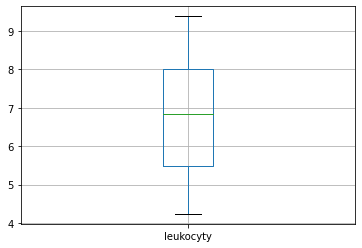

In [53]:
df_labor.boxplot(column=['leukocyty'])

In [54]:
release_outlier_ninja2()

<AxesSubplot:>

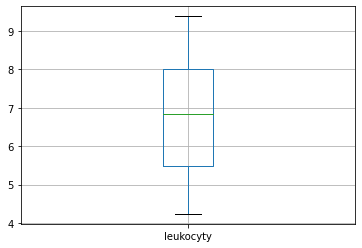

In [55]:
df_labor.boxplot(column=['leukocyty'])

#### Spojenie datasetov  

Spojenie datasetov riešime metódou dataframu **merge** na základe *_ssn_* a *_name_*:

In [56]:
df_merged = df_labor.merge(df_profiles, on=['ssn', 'name'], how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9734 entries, 0 to 9733
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   hemoglobin        9704 non-null   float64       
 1   leukocyty         9705 non-null   float64       
 2   etytr             9705 non-null   float64       
 3   weight            9734 non-null   float64       
 4   trombocyty        9704 non-null   float64       
 5   ast               9704 non-null   float64       
 6   alp               9704 non-null   float64       
 7   relationship      9734 non-null   category      
 8   name              9734 non-null   object        
 9   alt               9705 non-null   float64       
 10  hbver             9704 non-null   float64       
 11  smoker            9734 non-null   category      
 12  erytrocyty        9704 non-null   float64       
 13  er-cv             9704 non-null   float64       
 14  indicator         9734 n

Na základe **info** je potrebné riešiť transformáciu viacerých údajov na numerické

## 2. Realizácia predspracovania dát 

### Zadanie  
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)
    
### Riešenie



## 3. Výber atribútov pre strojové učenie

### Zadanie  
- Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”.
- Zoradíte tie atribúty v poradí podľa dôležitosti. 
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie) 

### Riešenie




## 4. Replikovateľnosť predspracovania

### Zadanie  
- Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
- Očakáva sa aj využitie možnosti sklearn.pipeline

### Riešenie  

 - Pre replikovateľnosť kódu znovu načítame dataset, aby sme mohli realizovať jednoltivé časti zadania vo funkciách:  

In [119]:
# read labor and profiles dataset
df_labor_ = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles_ = pd.read_csv('../../data/profiles.csv', sep='\t')

 - spojenie datasetov cez funkciu: 

In [120]:
# https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c
class MergeTransformer(TransformerMixin):
    """
    A tranformer for merging 2 datasets.
    """
    cols = list()
    
    def __init__(self, *args, **kwargs):
        """
        Initialize method.

        :param *args: 2 datasets are instance of pandas.core.frame.DataFrame
        :param **kwargs: dictionary of names of columns
        """
        self.data1 = args[0]
        self.data2 = args[1]
        for col in kwargs.values():
            self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to merge 2 datasets in *args with columns in **kwargs.

        :param X: 2 datasets are instance of pandas.core.frame.DataFrame
        :returns: pandas.core.frame.DataFrame
        """
        X = self.data1.merge(self.data2, on=self.cols, how = 'inner')
        return X
    
"""
def merge_datasets(*args, **kwargs):  
    cols = list()
    for col in kwargs.values():
        cols.append(col)
    return args[0].merge(args[1], on=cols, how='inner')
"""
#df_merged = merge_datasets(df_labor_, df_profiles_, column1 ='ssn',column2 ='name')
#df_merged.info()


"""
# pipeline pre spojenie dát
merge_pipeline = Pipeline(
    [('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn',column2 ='name'))]
)
df_merged = pd.DataFrame
df_merged = merge_pipeline.transform(df_merged)
df_merged
"""


"\n# pipeline pre spojenie dát\nmerge_pipeline = Pipeline(\n    [('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn',column2 ='name'))]\n)\ndf_merged = pd.DataFrame\ndf_merged = merge_pipeline.transform(df_merged)\ndf_merged\n"

 - odstránenie zadaných stĺpcov cez funkciu

In [121]:
class DropColsTransformer(TransformerMixin):
    """
    A tranformer for droping columns from the dataset.
    """
    
    def __init__(self, data, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            X = X.drop(self.cols, axis=1)
            return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    
    
"""
def drop_cols(data, *args):
    try:
        return data.drop(list(args), axis=1)
    except KeyError:
        print(f'Something from {args} not found in dataset!')   
"""
    

#df_merged = drop_cols(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', 'current_location', 
#                     'residence', 'address')
#df_merged.info()

"""
df_merged = pd.DataFrame()

# pipeline pre spojenie dát
merge_pipeline = Pipeline(
    [('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),
    ('dropCols', DropColsTransformer(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', 
                                      'current_location', 'residence', 'address'))
    ]
)
#merge_pipeline.fit(df_merged)
df_merged = merge_pipeline.transform(df_merged)
df_merged
"""

"\ndf_merged = pd.DataFrame()\n\n# pipeline pre spojenie dát\nmerge_pipeline = Pipeline(\n    [('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),\n    ('dropCols', DropColsTransformer(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', \n                                      'current_location', 'residence', 'address'))\n    ]\n)\n#merge_pipeline.fit(df_merged)\ndf_merged = merge_pipeline.transform(df_merged)\ndf_merged\n"

In [130]:
class GetNumericalTransformer(TransformerMixin):
    """
    A tranformer for getting numerical values from the dataset.
    """
    
    def __init__(self,  data, col, what, category=None, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param col: col to be transformed
        :param what: dictionary, transform based on this
        :param category: change type based on this
        :param *args: -
        """
        self.data = data
        self.col = col
        self.what = what
        self.category = category
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to transform column to a numeric and change a type.

        :param X: pandas.core.frame.DataFrame
        :returns: transformed pandas.core.frame.DataFrame
        :raises keyError: raises an exception in case column was not found
        """
        try:
            X[self.col].replace(self.what, inplace=True)
            if self.category is not None:
                X = X.astype({self.col: self.category})
            return X
        except KeyError:
            print(f'Something from {self.what} not found in dataset!')  

 - transformácia údajov

In [134]:
df_merged = pd.DataFrame()

# pipeline pre spojenie dát
merge_pipeline = Pipeline(
    [
        ('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),
        ('dropCols', DropColsTransformer(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', 
                                      'current_location', 'residence', 'address')),
        ('numSex', GetNumericalTransformer(df_merged, 'sex', {"M": 0, "F": 1}, 'category')),
        ('numBlood', GetNumericalTransformer(df_merged, 'blood_group', {
                "A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8
            }, 'category')
        ),
        ('numRepairRace', GetNumericalTransformer(df_merged, 'race', {
            "blsck": "Black", "black": "Black", "white": "White"})
        ),
        ('numRace', GetNumericalTransformer(df_merged, 'race', {
            "White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5}, 'category')
        )
    ]
)

df_merged = merge_pipeline.transform(df_merged)
df_merged


,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,birthdate,race
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,2.01576,9.04461,no,7.94417,61.31451,0.0,5.40103,1,2,18 Jul 1990,2
1,7.61474,8.32651,6.31797,103.40018,7.94740,68.19111,58.87708,married,0.97423,5.16036,Y,4.59597,55.12010,1.0,6.98459,1,2,18 Jul 1990,2
2,4.48849,4.23617,4.02665,81.31141,6.17807,61.68013,38.42977,married,1.08880,3.85662,yes,5.47003,59.69653,1.0,8.37171,1,2,18 Jul 1990,2
3,8.29277,5.51242,4.48835,47.93897,7.92536,64.28436,31.94522,separated,1.50041,8.15193,Y,4.55800,58.92745,0.0,5.91413,1,2,18 Jul 1990,2
4,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,0.81519,9.09262,no,5.33302,58.00624,0.0,7.68167,0,5,1906-08-23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,7.90745,5.63301,4.44871,55.44949,6.48412,71.57464,39.89552,single,0.98024,8.36677,N,5.71656,54.45230,0.0,7.02299,1,6,1959/06/24,2
10031,3.77544,5.10408,5.40890,77.94972,6.22491,71.35940,9.65906,nop,2.13598,7.87850,Y,8.13066,51.26987,0.0,6.25302,1,6,1959/06/24,2
10032,8.55132,8.53496,3.89371,72.94657,7.97233,70.47923,22.00857,single,0.78116,5.12016,no,4.86442,64.07401,1.0,6.42588,0,7,1927-05-07,5
10033,5.18230,6.72885,9.75421,61.89897,5.47435,61.28623,60.99741,divoced,3.01857,11.81792,N,8.33833,47.50924,1.0,6.26483,0,7,1927-05-07,5


In [60]:
def transform(data, col, what, category=None):
    """
    Function to transform column to a numeric and change a type.
    
    :param data: pandas.core.frame.DataFrame
    :param col: col to be transformed
    :param what: dictionary, transform based on this
    :param category: change type based on this
    :returns: transformed pandas.core.frame.DataFrame
    :raises keyError: raises an exception in case column was not found
    """
    try:
        data[col].replace(what, inplace=True)
        if category is not None:
            return data.astype({col: category})
    except KeyError:
        print(f'Something from {what} not found in dataset!')  

In [61]:
df_merged

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,birthdate,race
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,2.01576,9.04461,no,7.94417,61.31451,0.0,5.40103,F,A-,18 Jul 1990,Black
1,7.61474,8.32651,6.31797,103.40018,7.94740,68.19111,58.87708,married,0.97423,5.16036,Y,4.59597,55.12010,1.0,6.98459,F,A-,18 Jul 1990,Black
2,4.48849,4.23617,4.02665,81.31141,6.17807,61.68013,38.42977,married,1.08880,3.85662,yes,5.47003,59.69653,1.0,8.37171,F,A-,18 Jul 1990,Black
3,8.29277,5.51242,4.48835,47.93897,7.92536,64.28436,31.94522,separated,1.50041,8.15193,Y,4.55800,58.92745,0.0,5.91413,F,A-,18 Jul 1990,Black
4,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,0.81519,9.09262,no,5.33302,58.00624,0.0,7.68167,M,AB+,1906-08-23,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,7.90745,5.63301,4.44871,55.44949,6.48412,71.57464,39.89552,single,0.98024,8.36677,N,5.71656,54.45230,0.0,7.02299,F,AB-,1959/06/24,Black
10031,3.77544,5.10408,5.40890,77.94972,6.22491,71.35940,9.65906,nop,2.13598,7.87850,Y,8.13066,51.26987,0.0,6.25302,F,AB-,1959/06/24,Black
10032,8.55132,8.53496,3.89371,72.94657,7.97233,70.47923,22.00857,single,0.78116,5.12016,no,4.86442,64.07401,1.0,6.42588,M,O+,1927-05-07,Indian
10033,5.18230,6.72885,9.75421,61.89897,5.47435,61.28623,60.99741,divoced,3.01857,11.81792,N,8.33833,47.50924,1.0,6.26483,M,O+,1927-05-07,Indian


In [62]:
df_merged.race.value_counts()

White       5126
Black       2359
Asian        926
Hawaiian     557
Indian       517
black        333
white        120
blsck         97
Name: race, dtype: int64

In [63]:
#df_merged = transform(df_merged, 'sex', {"M": 0, "F": 1}, 'category')
#df_merged = transform(df_merged, 'blood_group', 
#                      {"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8}, 'category')
# oprav údaje
#transform(df_merged, 'race', {"blsck": "Black", "black": "Black", "white": "White"})
df_merged.race.value_counts()


White       5246
Black       2789
Asian        926
Hawaiian     557
Indian       517
Name: race, dtype: int64

In [64]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10035 entries, 0 to 10034
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   hemoglobin    10005 non-null  float64 
 1   leukocyty     10004 non-null  float64 
 2   etytr         10005 non-null  float64 
 3   weight        10035 non-null  float64 
 4   trombocyty    10005 non-null  float64 
 5   ast           10005 non-null  float64 
 6   alp           10004 non-null  float64 
 7   relationship  10035 non-null  object  
 8   alt           10005 non-null  float64 
 9   hbver         10005 non-null  float64 
 10  smoker        10035 non-null  object  
 11  erytrocyty    10005 non-null  float64 
 12  er-cv         10005 non-null  float64 
 13  indicator     10035 non-null  float64 
 14  hematokrit    10005 non-null  float64 
 15  sex           10035 non-null  category
 16  blood_group   10035 non-null  category
 17  birthdate     10035 non-null  object  
 18  race  

In [65]:
df_merged

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,birthdate,race
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,2.01576,9.04461,no,7.94417,61.31451,0.0,5.40103,1,2,18 Jul 1990,Black
1,7.61474,8.32651,6.31797,103.40018,7.94740,68.19111,58.87708,married,0.97423,5.16036,Y,4.59597,55.12010,1.0,6.98459,1,2,18 Jul 1990,Black
2,4.48849,4.23617,4.02665,81.31141,6.17807,61.68013,38.42977,married,1.08880,3.85662,yes,5.47003,59.69653,1.0,8.37171,1,2,18 Jul 1990,Black
3,8.29277,5.51242,4.48835,47.93897,7.92536,64.28436,31.94522,separated,1.50041,8.15193,Y,4.55800,58.92745,0.0,5.91413,1,2,18 Jul 1990,Black
4,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,0.81519,9.09262,no,5.33302,58.00624,0.0,7.68167,0,5,1906-08-23,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,7.90745,5.63301,4.44871,55.44949,6.48412,71.57464,39.89552,single,0.98024,8.36677,N,5.71656,54.45230,0.0,7.02299,1,6,1959/06/24,Black
10031,3.77544,5.10408,5.40890,77.94972,6.22491,71.35940,9.65906,nop,2.13598,7.87850,Y,8.13066,51.26987,0.0,6.25302,1,6,1959/06/24,Black
10032,8.55132,8.53496,3.89371,72.94657,7.97233,70.47923,22.00857,single,0.78116,5.12016,no,4.86442,64.07401,1.0,6.42588,0,7,1927-05-07,Indian
10033,5.18230,6.72885,9.75421,61.89897,5.47435,61.28623,60.99741,divoced,3.01857,11.81792,N,8.33833,47.50924,1.0,6.26483,0,7,1927-05-07,Indian
